<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/main/sample_emo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install keras-tuner
# !rm -r sentiment
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [93]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense, Embedding, Flatten
from keras.models import Sequential
from keras.metrics import Precision, Recall
from keras.optimizers import Adam, RMSprop
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate
from sklearn.utils import class_weight
import numpy as np
from imblearn.over_sampling import SMOTE

In [36]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/emotion/data/go_preprocessed.csv'
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
seed = 123456
num_words = 10000
max_len = 250

In [5]:
data = read_data(data_path,cols)
data.sample(5)

,text,target
18179,i love name but hate royals and wow this versi...,disgust
9465,traded me away the bastard kidding aside it th...,anger
50283,no the bubble is love the bubble is life with ...,joy
60913,we tried the place i go is just a rundown old ...,sadness
25851,name was good in my love from the star,joy


In [8]:
train, test = train_test_split(data, test_size=0.35, \
                             random_state=seed, stratify=data['target'])

In [9]:
val, test = train_test_split(test, test_size=0.5, \
                             random_state=seed, stratify=test['target'])

In [10]:
train.shape, val.shape, test.shape

((57870, 2), (15580, 2), (15581, 2))

In [11]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [17]:
sequence_train = get_sequences(tokenizer, max_len, train['text'])
sequence_val = get_sequences(tokenizer, max_len, val['text'])
sequence_test = get_sequences(tokenizer, max_len, test['text'])

In [18]:
print(val['target'].unique(), \
      train['target'].unique(), \
      test['target'].unique())

['joy' 'anger' 'disgust' 'surprise' 'sadness' 'fear'] ['fear' 'joy' 'sadness' 'anger' 'surprise' 'disgust'] ['sadness' 'surprise' 'anger' 'joy' 'disgust' 'fear']


In [19]:
train_target = OH_fit_transform(train['target'])
val_target = OH_transform(val['target'])
test_target = OH_transform(test['target'])

In [76]:
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train['target']),
#                                                  np.ravel(train['target']))

In [77]:
# class_weights

array([0.83796699, 3.66869532, 4.80568012, 0.42130782, 1.29567437,
       0.84701853])

In [ ]:
oversample = SMOTE()
sequence_train, train_target = oversample.fit_resample(sequence_train,\
                                                       train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [50]:
def build_mlp():
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(Dense(40, activation='sigmoid'))
    model.add(Dense(60, activation='sigmoid'))
    model.add(Dense(80, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(80, activation='sigmoid'))
    model.add(Dense(60, activation='sigmoid'))
    model.add(Dense(40, activation='sigmoid'))
    model.add(Dense(6, activation='softmax'))
    return model

In [28]:
def build_emb():
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(Embedding(num_words,32))
    model.add(Flatten())
    model.add(Dense(6, activation='softmax'))
    return model

In [51]:
mlp_model = build_mlp()
mlp_model.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
mlp_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 40)                10040     
_________________________________________________________________
dense_14 (Dense)             (None, 60)                2460      
_________________________________________________________________
dense_15 (Dense)             (None, 80)                4880      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               8100      
_________________________________________________________________
dense_17 (Dense)             (None, 80)                8080      
_________________________________________________________________
dense_18 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_19 (Dense)             (None, 40)               

In [56]:
mlp_cb = get_callbacks('mlp_3H.h5')

In [57]:
history_mlp = mlp_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs = 100,
    batch_size=64,
    callbacks=mlp_cb
)

Epoch 1/100
905/905 [==============================] - 4s 4ms/step - loss: 1.5289 - accuracy: 0.3956 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.5291 - val_accuracy: 0.3956 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.52914, saving model to mlp_3H.h5
Epoch 2/100
905/905 [==============================] - 3s 3ms/step - loss: 1.5290 - accuracy: 0.3956 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.5291 - val_accuracy: 0.3956 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00

Epoch 00002: val_loss improved from 1.52914 to 1.52906, saving model to mlp_3H.h5
Epoch 3/100
905/905 [==============================] - 3s 3ms/step - loss: 1.5290 - accuracy: 0.3956 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.5289 - val_accuracy: 0.3956 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00

Epoch 00003: val_loss improved from 1.52906 to 1.52895, saving model to mlp_3H.h5
Epoch 4/

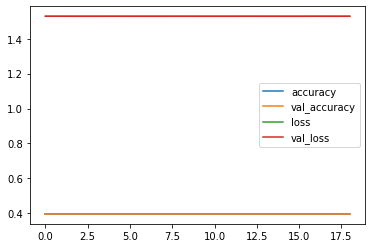

In [80]:
pd.DataFrame(history_mlp.history)[metr].plot()

 85/244 [=========>....................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


244/244 [==============================] - 0s 1ms/step
Accuracy:	39.6%


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3099
           1       0.00      0.00      0.00       708
           2       0.00      0.00      0.00       540
           3       0.40      1.00      0.57      6164
           4       0.00      0.00      0.00      2004
           5       0.00      0.00      0.00      3066

    accuracy                           0.40     15581
   macro avg       0.07      0.17      0.09     15581
weighted avg       0.16      0.40      0.22     15581



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


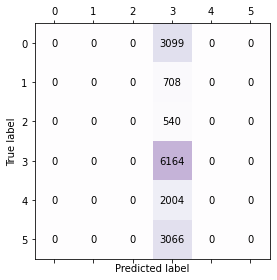

In [90]:
model_evaluate(mlp_model, sequence_test, test_target, 64)

In [78]:
mlp_model2 = build_mlp()
mlp_model2.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
mlp_model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 40)                10040     
_________________________________________________________________
dense_24 (Dense)             (None, 60)                2460      
_________________________________________________________________
dense_25 (Dense)             (None, 80)                4880      
_________________________________________________________________
dense_26 (Dense)             (None, 100)               8100      
_________________________________________________________________
dense_27 (Dense)             (None, 80)                8080      
_________________________________________________________________
dense_28 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_29 (Dense)             (None, 40)               

In [79]:
mlp2_cb = get_callbacks('mlp2_3H.h5')

In [88]:
history_mlp2 = mlp_model2.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs = 100,
    batch_size=64,
    callbacks=mlp2_cb,
    class_weight=dict(enumerate(class_weights))
)

Epoch 1/100
905/905 [==============================] - 3s 3ms/step - loss: 1.7921 - accuracy: 0.0957 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.7828 - val_accuracy: 0.3956 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00

Epoch 00001: val_loss improved from 1.78844 to 1.78282, saving model to mlp2_3H.h5
Epoch 2/100
905/905 [==============================] - 3s 3ms/step - loss: 1.7922 - accuracy: 0.1440 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.7892 - val_accuracy: 0.3956 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00

Epoch 00002: val_loss did not improve from 1.78282
Epoch 3/100
905/905 [==============================] - 3s 3ms/step - loss: 1.7921 - accuracy: 0.1556 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.7969 - val_accuracy: 0.0347 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00

Epoch 00003: val_loss did not improve from 1.78282
Epoch 4/100
905/905 [==============================] - 3s 3ms/ste

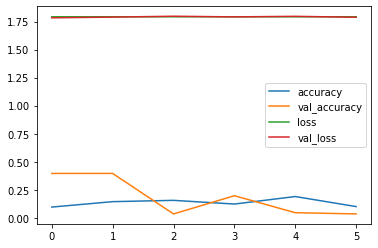

In [91]:
pd.DataFrame(history_mlp2.history)[metr].plot()

139/244 [================>.............] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


244/244 [==============================] - 0s 1ms/step
Accuracy:	39.6%


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3099
           1       0.00      0.00      0.00       708
           2       0.00      0.00      0.00       540
           3       0.40      1.00      0.57      6164
           4       0.00      0.00      0.00      2004
           5       0.00      0.00      0.00      3066

    accuracy                           0.40     15581
   macro avg       0.07      0.17      0.09     15581
weighted avg       0.16      0.40      0.22     15581



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


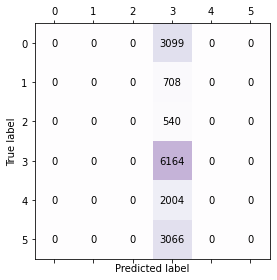

In [89]:
model_evaluate(mlp_model2, sequence_test, test_target, 64)

In [54]:
emb_cb = get_callbacks('emb.h5')

In [59]:
emb_model = build_emb()
emb_model.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
emb_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 32)           320000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 48006     
Total params: 368,006
Trainable params: 368,006
Non-trainable params: 0
_________________________________________________________________


In [60]:
history_emb = emb_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs = 100,
    batch_size=64,
    callbacks=emb_cb
)

Epoch 1/100
905/905 [==============================] - 11s 11ms/step - loss: 1.5705 - accuracy: 0.3917 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.5269 - val_accuracy: 0.3956 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.52694, saving model to emb.h5
Epoch 2/100
905/905 [==============================] - 9s 10ms/step - loss: 1.5260 - accuracy: 0.3942 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.5234 - val_accuracy: 0.3956 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00

Epoch 00002: val_loss improved from 1.52694 to 1.52342, saving model to emb.h5
Epoch 3/100
905/905 [==============================] - 9s 10ms/step - loss: 1.5220 - accuracy: 0.3954 - precision_7: 0.4282 - recall_7: 8.1752e-05 - val_loss: 1.5180 - val_accuracy: 0.3956 - val_precision_7: 1.0000 - val_recall_7: 1.9255e-04

Epoch 00003: val_loss improved from 1.52342 to 1.51803, saving model to emb.h5
Epoch 4/100
905/905 [

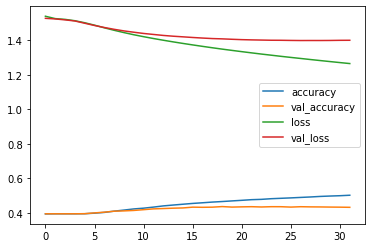

In [61]:
pd.DataFrame(history_emb.history)[metr].plot()

 49/244 [=====>........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


244/244 [==============================] - 1s 2ms/step
Accuracy:	43.1%


              precision    recall  f1-score   support

           0       0.31      0.36      0.34      3099
           1       0.00      0.00      0.00       708
           2       0.00      0.00      0.00       540
           3       0.50      0.78      0.61      6164
           4       0.34      0.10      0.15      2004
           5       0.33      0.19      0.24      3066

    accuracy                           0.43     15581
   macro avg       0.25      0.24      0.22     15581
weighted avg       0.37      0.43      0.37     15581



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


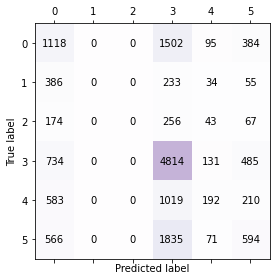

In [70]:
model_evaluate(emb_model, sequence_test, test_target, 64)